In [5]:
%load_ext autoreload
%autoreload 2
%load_ext Cython

from __future__ import division
from __future__ import print_function

import sys,time,datetime,copy,subprocess,itertools,pickle,warnings,json,gc,numbers

import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl

In [6]:
import Hawkes as hk

para = {"mu":0.1, "alpha":0.5, "beta":10.0}
itv = [0,10000]

h1 = hk.simulator().set_kernel('exp').set_baseline('const').set_parameter(para)
T = h1.simulate(itv)
print(len(T))

h2 = hk.estimator().set_kernel('exp').set_baseline('const')
h2.fit(T,itv)
print(h2.para)

print()
%timeit -n1 -r1 h2.fit(T,itv)

2052
{'beta': 10.33666033282947, 'alpha': 0.4812257447678529, 'mu': 0.10645247676806636}

7.24 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [7]:
import Hawkes as hk

para = {"mu":0.1, "alpha":[0.25,0.25], "beta":[1.0,20.0]}
itv = [0,10000]

h1 = hk.simulator().set_kernel('exp',num_exp=2).set_baseline('const').set_parameter(para)
T = h1.simulate(itv)
print(len(T))

h2 = hk.estimator().set_kernel('exp',num_exp=2).set_baseline('const')
h2.fit(T,itv)
print(h2.para)

print()
%timeit -n1 -r1 h2.fit(T,itv)

1997
{'beta': array([ 0.9448391 , 17.66044387]), 'alpha': array([0.21389074, 0.26708937]), 'mu': 0.10364827211103662}

12.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [8]:
import Hawkes as hk

para = {"mu":0.1, "k":0.5,"p":2.0,"c":1.0}
itv = [0,10000]

h1 = hk.simulator().set_kernel('pow').set_baseline('const').set_parameter(para)
T = h1.simulate(itv)
print(len(T))

h2 = hk.estimator().set_kernel('pow').set_baseline('const')
h2.fit(T,itv)
print(h2.para)

print()
%timeit -n1 -r1 h2.fit(T,itv)

1919
{'p': 1.7114724294641388, 'k': 0.31941643637870515, 'c': 0.7433907457286282, 'mu': 0.08599435695796154}

1.23 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


1263
{'beta': 4.02875367643776, 'alpha': 0.29075588848114353, 'mu': array([10.9452755 , 19.20740066, 11.88446083,  4.18720104,  0.10195652,
        7.77525893])}
{'beta': 2.7497551608411626, 'alpha': 0.40985176049725497, 'mu': array([ 2.61727192e+00,  5.40627319e-01,  5.42149883e+00, -1.18469636e+00,
       -6.70678134e-03,  8.67613301e+00])}


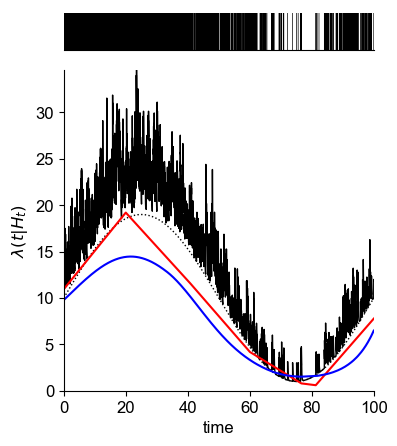

In [9]:
import Hawkes as hk

para = {"alpha":0.2,"beta":10.0}
mu_t = lambda x: 10.0 + 9.0*np.sin(2*np.pi*x/100)
itv = [0,100]
h1 = hk.simulator().set_kernel("exp").set_baseline('custom',l_custom=mu_t).set_parameter(para)
T = h1.simulate(itv)
print(len(T))

# piecewise lienar model
h2 = hk.estimator().set_kernel("exp").set_baseline('plinear',num_basis=6)
h2.fit(T,itv)
print(h2.para)

# log-linear model
h3 = hk.estimator().set_kernel("exp").set_baseline('loglinear',num_basis=6)
h3.fit(T,itv)
print(h3.para)

h1.plot_l()
plt.plot(T,h2.baseline.l(T),"r-")
plt.plot(T,h3.baseline.l(T),"b-")
pass

10126


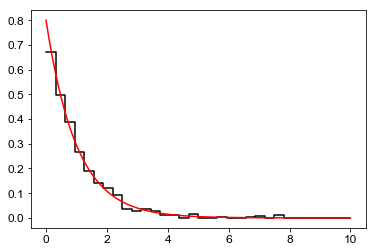

In [18]:
########################## non-parametric model
import Hawkes as hk

para = {"mu":0.2, "alpha":0.8, "beta":1.0}
itv = [0,10000]

h1 = hk.simulator().set_kernel('exp').set_baseline('const').set_parameter(para)
T = h1.simulate(itv)
print(len(T))

support = 10.0
num_bin = 32

###
h2 = hk.estimator().set_kernel('nonpara',support=support,num_bin=num_bin).set_baseline('const')
h2.fit(T,itv)

h2.kernel.plot()
x = np.linspace(0,support,100)
y = np.exp(-1.0*x)*0.8*1.0
plt.plot(x,y,'r-')